# [Two Sigma Financial Modelling Challenge](https://www.kaggle.com/c/two-sigma-financial-modeling)
Can you uncover predictive value in an uncertain world? Hosted by [Kaggle](https://www.kaggle.com)

#### In this notebook
1. Preprocess
2. Model (LSTM)
    1. Sanity Check: One time series
    2. Sanity Check: Two time series
3. Training

Todo:
- sanity check: sin prediction based on cos and tan -- **MAT**
- sampling without replacement? (i.e. in each epoch, each training example is looked at exactly once)

In [1]:
'''Here are all the modules we will be using in this notebook. Make sure you can import everything before moving on!'''

import numpy as np
import pandas as pd
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

data_root = './data/'

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def dyn_plot(history):
    plt.clf()
    plt.plot(history)
    display.clear_output(wait=True)
    display.display(plt.gcf())

## Part 1: Preprocess

We split the training data into training, validation and test sets holding pairwise disjoint timestamps.
These dataframes may share instruments.

In [ ]:
raw_df = pd.read_hdf(data_root + 'train.h5')

num_time_stamps = len(raw_df['timestamp'].unique())
valid_start_ind = int(num_time_stamps * 0.5)
test_start_ind = int(num_time_stamps * 0.8)

raw_train_df = raw_df[raw_df['timestamp'] < valid_start_ind]
# raw_valid_df = raw_df[(raw_df['timestamp'] < test_start_ind) & (raw_df['timestamp'] >= valid_start_ind)]
# raw_test_df = raw_df[(raw_df['timestamp'] <= test_start_ind)]

raw_df = None # Release memory

#### Next, we create a Transformer

__Fit:__ Calculates the median, mean and std of each column

__Transform:__

* Fills the missing values with the median of each column
  * Here I chose median to prevent the outliers from shifting the values by a large margin
* Limits the values within each column to 5 std from the average to remove the outliers
* Normalizes the features (subtract the mean and divide by std)

In [ ]:
class Transformer:
    def __init__(self, untouched=['id', 'timestamp', 'y']):
        '''untouched is a list of column names to ignore when transforming the dataframes'''
        self.untouched = untouched
    def fit(self, df):
        '''df is a dataframe to extract metadata (median, mean and std, of each column) '''
        self.median = df.median()
        self.mean = df.mean()
        self.std = df.std()
    def transform(self, df):
        '''
        Given a dataframe,
        it fills the missing attributes with the median of each column,
        limits the values of each column to between 5 STD from the mean,
        and normalizes the features
        '''
        # Fill the missing attributes with the median of each column
        df.fillna(self.median, inplace=True)
        # Limit the values of each column to between 5 STD from the mean
        col_names = [col for col in df.columns if col not in self.untouched]
        for cn in col_names:
            lower = self.mean[cn] - 5 * self.std[cn]
            upper = self.mean[cn] + 5 * self.std[cn]
            df.loc[:, cn] = df.loc[:, cn].clip(lower=lower, upper=upper)
        # Normalize the features
        for cn in col_names:
            df.loc[:, cn] = (df.loc[:, cn] - self.mean[cn]) / self.std[cn]
        return df

In [ ]:
T = Transformer()
T.fit(raw_train_df)

train_df = T.transform(raw_train_df)
raw_train_df = None # Release Memory
print('processed training dataframe')

# valid_df = T.transform(raw_valid_df)
# raw_valid_df = None # Release Memory
# print('processed validation dataframe')

# test_df = T.transform(raw_test_df)
# raw_test_df = None # Release Memory
# print('processed test dataframe')

## Part 2: Model

In [3]:
class Model:
    def __init__(self, num_feat, lstm_size, fc_hidd_size, lr):
        self.num_feat = num_feat
        self.lstm_size = lstm_size
        self.fc_hidd_size = fc_hidd_size
        self.lr = lr
        self.build_graph()
    def build_graph(self):
        '''Input'''
        self.X = tf.placeholder(dtype=tf.float64, shape=[None, None, self.num_feat], name='X')
        self.y = tf.placeholder(dtype=tf.float64, shape=[None, None, 1], name='y')
        self.sequence_length = tf.placeholder(dtype=tf.int64, shape=[None], name='sequence_length')
        self.target_mask = tf.placeholder(dtype=tf.float64, shape=[None, None, 1], name='target_mask')
        
        '''LSTM'''
        lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units=self.lstm_size, initializer=tf.contrib.layers.xavier_initializer())
        # The initial state of the LSTM
        state_shape = [None, self.lstm_size]
        self.state_c = tf.placeholder(dtype=tf.float64, shape=state_shape)
        self.state_h = tf.placeholder(dtype=tf.float64, shape=state_shape)
        initial_state = tf.nn.rnn_cell.LSTMStateTuple(self.state_c, self.state_h)
        
        self.output, self.state = tf.nn.dynamic_rnn(
            cell=lstm_cell,
            dtype=tf.float64,
            sequence_length=self.sequence_length,
            initial_state=initial_state,
            inputs=self.X
        )
        
        self.f0 = tf.contrib.layers.fully_connected(
            self.output, num_outputs=self.fc_hidd_size,
            activation_fn=tf.nn.relu, weights_initializer=tf.contrib.layers.xavier_initializer())
        self.pred = tf.contrib.layers.fully_connected(
            self.f0, num_outputs=1, weights_initializer=tf.contrib.layers.xavier_initializer())
        self.pred_masked = tf.mul(self.pred, self.target_mask)
        
        '''Loss'''
        self.errors = tf.squared_difference(self.y, self.pred_masked)
        self.loss = tf.reduce_mean(self.errors)
        
        '''Optimize'''
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=self.lr,
            beta1=0.9, beta2=0.999,
            epsilon=1e-08,
            use_locking=False,
            name='Adam'
        ).minimize(self.loss)
        
    def train_on_batch(self, session, sequence, sequence_targets, target_mask, sequence_length):
        batch_size = len(sequence)
        
        feed_dict = {
            self.X: sequence,
            self.y: sequence_targets,
            self.target_mask: target_mask,
            self.sequence_length: sequence_length,
            self.state_c: np.zeros(shape=[batch_size, self.lstm_size]),
            self.state_h: np.zeros(shape=[batch_size, self.lstm_size])
        }

        loss, _ = session.run([self.loss, self.optimizer], feed_dict=feed_dict)
        return loss
    
    def predict(self, session, sequence, sequence_length, initial_state=None):
        feed_dict = {self.X: sequence, self.sequence_length: sequence_length}
        if initial_state is None:
            batch_size = len(sequence)
            feed_dict[self.state_c] = np.zeros(shape=[batch_size, self.lstm_size])
            feed_dict[self.state_h] = np.zeros(shape=[batch_size, self.lstm_size])
        else:
            feed_dict[self.state_c] = initial_state.c
            feed_dict[self.state_h] = initial_state.h
        
        pred, state = session.run([self.pred, self.state], feed_dict=feed_dict)
        return pred, state        
        
    def fit(self, session, input_df, num_epoch, batch_size):
        examples = {}
        for _id, df in input_df.groupby('id'):
            exp = []
            exp.append(df.drop(['id', 'y'], axis=1).values)
            exp.append(df['y'].values)
            exp.append(df.shape[0])
            examples[_id] = exp
                
        keys = examples.keys()
        num_seq = len(keys)
        num_batch = ((num_seq / batch_size) + 1) * num_epoch
        
        for _ in range(num_batch):
            batch_keys = np.random.choice(keys, batch_size, False)
            batch = [examples[k] for k in batch_keys]
            X, y, ln = zip(*batch)
            
            max_len = max(ln)
            feat = [np.pad(s, ((0, max_len - s.shape[0]), (0, 0)), 'constant') for s in X]
            tar = [np.pad(t, ((0, max_len - t.shape[0])), 'constant') for t in y]
            mask = [np.pad(np.ones_like(t), ((0, max_len - t.shape[0])), 'constant') for t in y]
            feat, tar, mask = np.array(feat), np.expand_dims(np.array(tar), 2), np.expand_dims(np.array(mask), 2)
            
            loss = self.train_on_batch(session, feat, tar, mask, ln)
            yield loss[0]

### A: Sanity check one time series

In [4]:
sanity_df = pd.read_csv('international-airline-passengers.csv',
                      usecols=[1], 
                      engine='python', 
                      skipfooter=3)

In [5]:
train_prop = 0.66
num_days = sanity_df.shape[0]

In [6]:
dataset = sanity_df[:int(train_prop * num_days)].values
dataset = dataset.astype('float32')
train_min = min(dataset)[0]
train_max = max(dataset)[0]
dataset = (dataset - train_min)/(train_max - train_min)

x_vals = np.expand_dims(dataset[0:-2],axis=0)
y_vals = np.expand_dims(dataset[1:-1],axis=0)

In [7]:
# Params
num_epoch = 400
batch_size = 1
num_feat = 1
lstm_size = 128 #1024
fc_hidd_size = 64 #256
lr = 1e-3

M = Model(num_feat=num_feat, lstm_size=lstm_size, fc_hidd_size=fc_hidd_size, lr=lr)
session = tf.Session()
session.run(tf.global_variables_initializer())

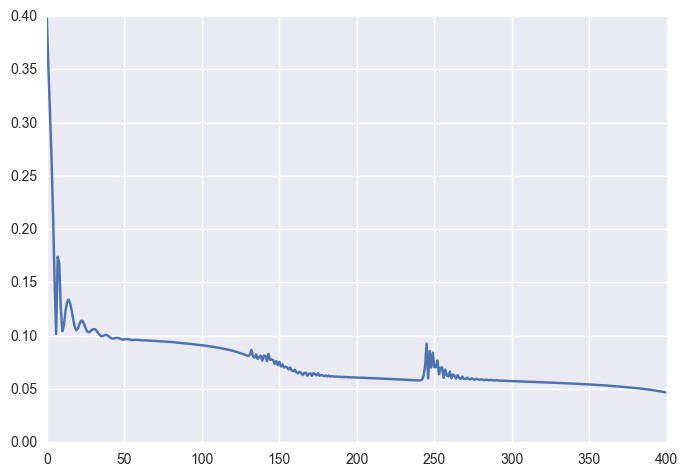

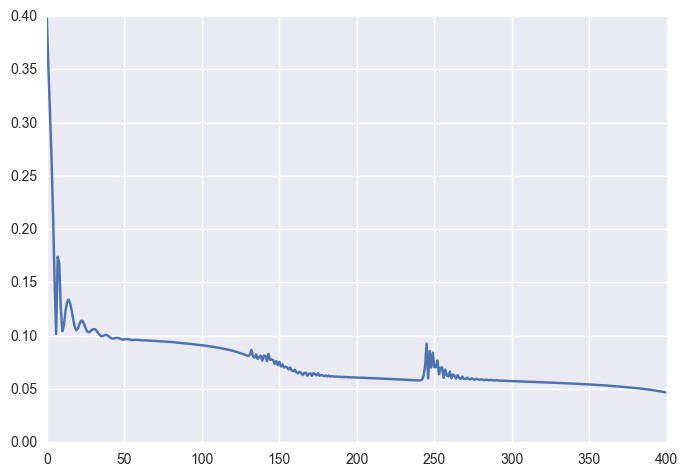

In [8]:
history = []
for _ in range(num_epoch):
    history.append(M.train_on_batch(sequence=x_vals,
                     sequence_length=np.array([x_vals.shape[1]]),
                     sequence_targets=y_vals,
                     target_mask=np.ones_like(y_vals),
                     session=session)
                  )
    dyn_plot(np.sqrt(history))

Check against the whole dataset

In [9]:
test_dataset = sanity_df.values
test_dataset = test_dataset.astype('float32')
test_dataset = (test_dataset - train_min)/(train_max - train_min)

test_x_vals = np.expand_dims(test_dataset[0:-2],axis=0)
test_y_vals = np.expand_dims(test_dataset[1:-1],axis=0)

In [10]:
pred, _ = M.predict(sequence=test_x_vals,
                    sequence_length=np.array([test_x_vals.shape[1]]),
                    session=session)

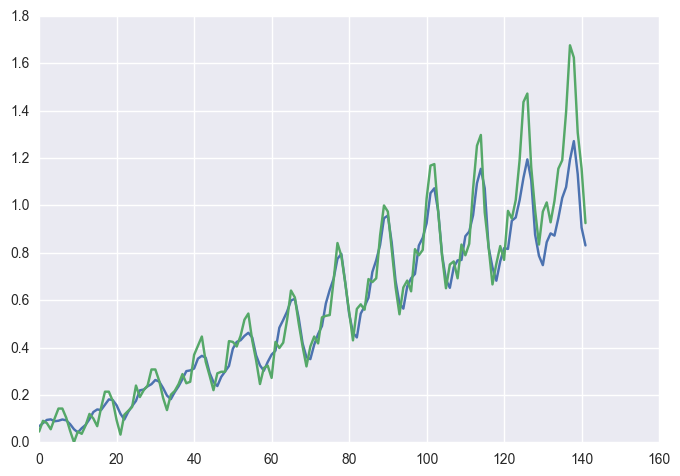

In [11]:
plt.plot(pred[0])
plt.plot(test_y_vals[0])

### B: Sanity check two series

In [ ]:
sanity_df = pd.read_csv('international-airline-passengers.csv',
                      usecols=[1], 
                      engine='python', 
                      skipfooter=3)

Plan: one batch with be the time series going forwards, and the other will be backwards

In [ ]:
train_prop = 0.66
num_days = sanity_df.shape[0]

Normal forwards dataset

In [ ]:
dataset = sanity_df[:int(train_prop * num_days)].values
dataset = dataset.astype('float32')
train_min = min(dataset)[0]
train_max = max(dataset)[0]
dataset = (dataset - train_min)/(train_max - train_min)

forwards_x_vals = np.expand_dims(dataset[0:-2],axis=0)
forwards_y_vals = np.expand_dims(dataset[1:-1],axis=0)

Backwards Dataset

In [ ]:
reverse_df = sanity_df[::-1].reset_index(drop=1)

rev_dataset = reverse_df[:int(train_prop * num_days)].values
rev_dataset = rev_dataset.astype('float32')
rev_train_min = min(rev_dataset)[0]
rev_train_max = max(rev_dataset)[0]
rev_dataset = (rev_dataset - rev_train_min)/(rev_train_max - rev_train_min)

rev_x_vals = np.expand_dims(rev_dataset[0:-2],axis=0)
rev_y_vals = np.expand_dims(rev_dataset[1:-1],axis=0)

Make the training data

In [ ]:
x_vals = np.concatenate((forwards_x_vals,rev_x_vals),axis = 0)
y_vals = np.concatenate((forwards_y_vals,rev_y_vals),axis = 0)

In [ ]:
# Params
num_epoch = 400
batch_size = 2
num_feat = 1
lstm_size = 128 #1024
fc_hidd_size = 64 #256
lr = 1e-3

M = Model(num_feat=num_feat, lstm_size=lstm_size, fc_hidd_size=fc_hidd_size, lr=lr)
session = tf.Session()
session.run(tf.global_variables_initializer())

update: below doesn't work :(

In [ ]:
history = []
for _ in range(num_epoch):
    history.append(M.train_on_batch(sequence=x_vals,
                     sequence_length=np.array([x_vals.shape[1]]),
                     sequence_targets=y_vals,
                     target_mask=np.ones_like(y_vals),
                     session=session)
                  )
    dyn_plot(np.sqrt(history))

## Part 3: Train

__dyn_plot__ helps visualize the learning process dynamically. For details, read the answer by [HYRY](http://stackoverflow.com/users/772649/hyry):

* [how to dynamically update a plot in a loop in ipython notebook within one cell](http://stackoverflow.com/questions/21360361/how-to-dynamically-update-a-plot-in-a-loop-in-ipython-notebook-within-one-cell)

In [ ]:
# Params
num_epoch = 400
batch_size = 128
num_feat = 109
lstm_size = 128 #1024
fc_hidd_size = 64 #256
lr = 1e-3

M = Model(num_feat=num_feat, lstm_size=lstm_size, fc_hidd_size=fc_hidd_size, lr=lr)
session = tf.Session()
session.run(tf.global_variables_initializer())
    
history = []
for loss in M.fit(session, train_df, num_epoch, batch_size):
    history.append(loss)
    dyn_plot(np.sqrt(history))